In [1]:
import polars as pl
import polars_ds as pds
import polars.selectors as cs
import seaborn as sns
from utils import prep,dato_mapping_pub_trening,datoformat_mapping
import matplotlib.pyplot as plt
from datetime import date


c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Les inn data 

In [2]:
df = pl.read_excel("treningsdata.xlsx")
df.head()


Dato,Navn,Deltok,Avlyst trening
i64,str,str,str
20240106,"""Erlend Haukefer Hauan""","""Ja""","""Ja"""
20240106,"""Bakary Jang Konateh""","""Ja""","""Ja"""
20240106,"""Sindre Haukefer Hauan""","""Ja""","""Ja"""
20240204,"""Yafee Ishraq""","""Nei""","""Ja"""
20240204,"""Erlend Haukefer Hauan""","""Nei""","""Ja"""


In [3]:
(df
.with_columns(pl.col('Dato').cast(pl.String).str.strptime(pl.Date, "%Y%m%d", strict=False).alias('Ny Dato'))
.filter(pl.col('Ny Dato').dt.year()==2024,
        pl.col('Ny Dato').dt.month()==9
        )
)

Dato,Navn,Deltok,Avlyst trening,Ny Dato
i64,str,str,str,date
20240908,"""Carlos Tveit""","""Nei""","""Ja""",2024-09-08
20240908,"""Stian Nyheim""","""Nei""","""Ja""",2024-09-08
20240908,"""Ruben André M. Njøtøy""","""Nei""","""Ja""",2024-09-08
20240908,"""Jørgen Vassenden""","""Nei""","""Ja""",2024-09-08
20240908,"""Ahmed Abusaada""","""Nei""","""Ja""",2024-09-08
20240908,"""Sondre Foldenes Gangdal""","""Nei""","""Ja""",2024-09-08
20240908,"""Yafee Ishraq""","""Ja""","""Nei""",2024-09-08
20240908,"""Sindre Haukefer Hauan""","""Ja""","""Nei""",2024-09-08
20240908,"""Thomas Thorbjørnsen""","""Ja""","""Nei""",2024-09-08


In [ ]:
df = (df
.pipe(datoformat_mapping)
.pipe(dato_mapping_pub_trening)
.pipe(prep)
)


In [7]:
df.head()

Dato,Navn,Deltok,Avlyst trening,Treningsdato,År,Måned,Dag,Måned navn,Årstid
date,str,str,str,date,i32,i8,i8,str,str
2024-01-06,"""Erlend Haukefer Hauan""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-01-06,"""Bakary Jang Konateh""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-01-06,"""Sindre Haukefer Hauan""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-02-04,"""Yafee Ishraq""","""Nei""","""Ja""",2024-02-05,2024,2,1,"""Februar""","""vinter"""
2024-02-04,"""Erlend Haukefer Hauan""","""Nei""","""Ja""",2024-02-05,2024,2,1,"""Februar""","""vinter"""


In [12]:
treningsstreak = (df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Navn')=='Sindre Haukefer Hauan',
        pl.col('År')==2025
        )       
.group_by('Navn')
.agg(pl.col('Dato').filter(pl.col('Deltok')=='Ja').n_unique().alias('Totalt antall treninger'),
     pl.col('Dato').filter(pl.col('Deltok')=='Ja').min().cast(pl.Date).alias('Første trening'),
     pl.col('Dato').filter(pl.col('Deltok')=='Ja').max().cast(pl.Date).alias('Siste trening'),
     pds.query_longest_streak(pl.col('Deltok')=='Ja').alias('Streak')
     )
)

treningsstreak

Navn,Totalt antall treninger,Første trening,Siste trening,Streak
str,u32,date,date,u32
"""Sindre Haukefer Hauan""",12,2025-01-20,2025-04-27,6


c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


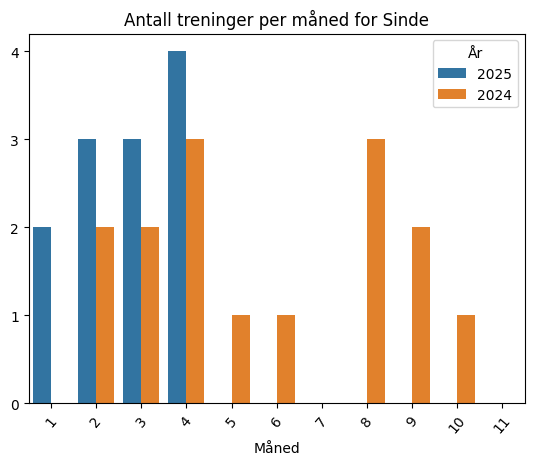

In [27]:
aar = 2025

from matplotlib.ticker import MaxNLocator

# Henter ut sortert liste over måneder
maaned_sort = df.select('Måned', 'Måned navn').unique().sort(by ='Måned',descending=False)['Måned'].to_list()

topp_10 = (df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja',
        pl.col('Navn')=='Sindre Haukefer Hauan',
        pl.col('År').is_in([aar,aar-1])
        )
.group_by('Navn','År','Måned')
.agg(pl.col('Dato').n_unique().cast(pl.Int64).alias('Antall treninger'))
.sort(by = ['Måned','År'],descending=[False,False])
.with_columns(pl.col(['Måned', 'År']).cast(pl.Utf8))
)

fig, ax = plt.subplots()
sns.barplot(data=topp_10.to_pandas(), x='Måned', y='Antall treninger',hue = 'År',ax = ax,order=maaned_sort)
ax.set_title(f'Antall treninger per måned for Sinde')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(ylabel=None) 

# Roter x-labels
ax.tick_params(axis='x', rotation=50)


In [7]:
(df
.filter(pl.col('Treningsdato').dt.year()==2024,
        pl.col('Treningsdato').dt.month()==9
        )
.group_by('Måned')
.agg( 
      pl.when(pl.col('Treningsdato').filter(pl.col('Avlyst trening')=='Nei').n_unique()==1)
      .then(
      pl.col('Navn')
      .filter(pl.col('Deltok')=='Ja')
      .n_unique()
      )
      .otherwise(
      pl.col('Navn')
      .filter(pl.col('Deltok')=='Ja')
      .len()
      .truediv(pl.col('Treningsdato').filter(pl.col('Avlyst trening')=='Nei').n_unique())
     )
     .alias('Antall per trening')
     )
)

Måned,Antall per trening
i8,f64
9,5.5


In [6]:
df

Dato,Navn,Deltok,Avlyst trening,Treningsdato,År,Måned,Dag,Måned navn,Årstid
date,str,str,str,date,i32,i8,i8,str,str
2024-01-06,"""Erlend Haukefer Hauan""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-01-06,"""Bakary Jang Konateh""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-01-06,"""Sindre Haukefer Hauan""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-02-04,"""Yafee Ishraq""","""Nei""","""Ja""",2024-02-05,2024,2,1,"""Februar""","""vinter"""
2024-02-04,"""Erlend Haukefer Hauan""","""Nei""","""Ja""",2024-02-05,2024,2,1,"""Februar""","""vinter"""
…,…,…,…,…,…,…,…,…,…
2025-05-18,"""Magnus Alexander Gjerde Bevan""","""Ja""","""Nei""",2025-05-21,2025,5,3,"""Mai""","""vår"""
2025-05-18,"""Johannes Aarra""","""Ja""","""Nei""",2025-05-21,2025,5,3,"""Mai""","""vår"""
2025-05-18,"""Markus Bjånesøy""","""Ja""","""Nei""",2025-05-21,2025,5,3,"""Mai""","""vår"""


In [12]:
(df
.select('Dato','Måned nr','Måned')
.filter(pl.col('Dato').dt.year()==2024,pl.col('Dato').dt.month()==9)

)

Dato,Måned nr,Måned
date,i8,str
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
…,…,…
2024-09-09,9,"""September"""
2024-09-09,9,"""September"""
2024-09-09,9,"""September"""


In [10]:
# Skal koble på den første mandagen etter publiseringsdato

# Henter ut max og min dato
aar_max = int(df.select('År').max().item())
aar_min = int(df.select('År').min().item())

alle_datoer = pl.DataFrame({'alle_dato':pl.date_range(date(aar_min, 1, 1), date(aar_max, 12, 1), "1d", eager=True)})

publiseringsdato = df.select('Dato').unique().rename({'Dato':'publiseringsdato'})


In [ ]:
publiseringsdato = (publiseringsdato

# Kobler på alle datoer som er større enn publiseringsdato
.join_where(
alle_datoer,

# Denne inequalitien vil sikre at dersom èn har publisert trening samme dag som det skal være trening
pl.col('publiseringsdato')<=pl.col('alle_dato')
)

# Ekstraherer ukedag
.with_columns(pl.col('alle_dato').dt.weekday().alias('dag'))

# Identifiserer hva som er den første mandagen ellers onsdag
 .group_by('publiseringsdato')
 .agg(
     
    # Første mandag  
    pl.col('alle_dato').filter(pl.col('dag')==1).min().alias('forste_mandag'),

    # Første onsdag
    pl.col('alle_dato').filter(pl.col('dag')==3).min().alias('forste_onsdag')
    
    )

# Dersom det er 2024 brukes mandag, hvis ikke brukes onsdag. Må sannsynligvis endre på logikken om flere år inkluderes i datasettet
.with_columns(pl.when(pl.col('publiseringsdato').dt.year()==2024)
              .then(pl.col('forste_mandag'))
              .otherwise(pl.col('forste_onsdag'))
              .alias('treningsdato')
)

# Fjerner forste_ kolonnene
.select(~cs.starts_with('forste'))

# Det kan være tilfeller hvor treningsdato har to eller flere publiseringsdato. Dette kan for eksempel forekomme dersom èn har publisert trening to ganger etter første mandagen i uken, som foreksempel
# 2024-07-25 (torsdag) og 2024-07-28 (søndag). Derfor tas det unike radene av treningsdato
.unique(subset='treningsdato')

)



# Må ta en inner join fordi vi fjerner duplikater av tilfeller hvor treningsdato har 2 eller flere publiseringsdato
df = (df
.join(other = publiseringsdato,left_on='Dato',right_on='publiseringsdato',how = 'inner')
.drop('Dato')
.rename({'treningsdato':'Dato'})
)


Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr,Dato
str,str,str,str,str,i64,i64,date
"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1,2024-01-08
"""Bakary Jang Konateh""","""Ja""","""Ja""","""2024""","""Januar""",6,1,2024-01-08
"""Sindre Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1,2024-01-08
"""Yafee Ishraq""","""Nei""","""Ja""","""2024""","""Februar""",4,2,2024-02-05
"""Erlend Haukefer Hauan""","""Nei""","""Ja""","""2024""","""Februar""",4,2,2024-02-05
…,…,…,…,…,…,…,…
"""Magnus Alexander Gjerde Bevan""","""Ja""","""Nei""","""2025""","""Mai""",18,5,2025-05-21
"""Johannes Aarra""","""Ja""","""Nei""","""2025""","""Mai""",18,5,2025-05-21
"""Markus Bjånesøy""","""Ja""","""Nei""","""2025""","""Mai""",18,5,2025-05-21


In [9]:
(df
.group_by('Navn','Måned')
.agg(pds.query_longest_streak(pl.col('Deltok')=='Ja').alias('Streak'))
#.filter(pl.col('Navn').str.contains('Erlend'))
.sort(by = 'Streak')
)

Navn,Måned,Streak
str,str,u32
"""Carlos Tveit""","""September""",0
"""Patrick Waage Seljenes""","""Oktober""",0
"""Thomas Thorbjørnsen""","""Mai""",0
"""Patrick Waage Seljenes""","""Juni""",0
"""Ruben André M. Njøtøy""","""Mai""",0
…,…,…
"""Sindre Jakobsen""","""April""",4
"""Sindre Jakobsen""","""August""",5
"""Thomas Thorbjørnsen""","""August""",5


In [44]:
pl.Config(tbl_rows=50)
df.filter(pl.col('Navn')=='Erlend Haukefer Hauan')

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-01-06,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1
2024-02-04,"""Erlend Haukefer Hauan""","""Nei""","""Ja""","""2024""","""Februar""",4,2
2024-02-17,"""Erlend Haukefer Hauan""","""Nei""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""Mars""",8,3
2024-04-20,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""April""",20,4
2024-04-28,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""April""",28,4
2024-05-05,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Mai""",5,5


<Axes: xlabel='Antall treninger', ylabel='Count'>

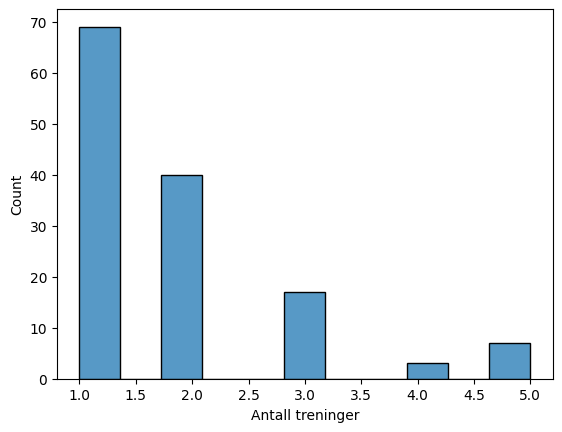

In [36]:
antall_treninger_deltaker = df.filter(pl.col('Avlyst trening')=='Nei').group_by('Navn','Måned').agg(pl.col('Dato').n_unique().alias('Antall treninger'))

fig, ax = plt.subplots()
sns.histplot(data = antall_treninger_deltaker.to_pandas(),x='Antall treninger',ax = ax)

# Roter x-labels
#ax.tick_params(axis='x', rotation=50)
#ax.set_ylabel("")
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_title('Antall treninger per måned')

In [30]:
antall_treninger.filter(pl.col('Måned')=='April')

Måned,variable,value
str,str,u32
"""April""","""Antall avlyste treninger""",3
"""April""","""Antall treninger""",3


In [6]:
(df
.group_by('Navn')
.agg(
     pl.col('Dato').filter(pl.col('Deltok')=='Ja').n_unique().alias('Antall treninger'),
     pl.col('Dato')
     .filter(pl.col('Deltok')=='Ja')
     .n_unique()
     .truediv(pl.col('Dato').n_unique())
     .alias('Andel treninger'))
#.sort(by = ['Antall treninger'])
)

Navn,Antall treninger,Andel treninger
str,u32,f64
"""Håkon Halvorsen""",1,0.5
"""Magnus Alexander Gjerde Bevan""",2,0.5
"""Ahmed Abusaada""",4,0.8
"""Markus Bjånesøy""",4,0.210526
"""Helge Håvås""",5,0.833333
…,…,…
"""Adrian S.Larsen""",2,0.5
"""Magnus Jensen""",0,0.0
"""Sondre Foldenes Gangdal""",0,0.0


In [18]:
df.sort(by = ['Navn', 'Dato'])

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-02-17,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""","""2024""","""Mars""",8,3
2024-07-28,"""Adrian Torvund""","""Ja""","""Nei""","""2024""","""Juli""",28,7
…,…,…,…,…,…,…,…
2024-10-02,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",2,10
2024-10-08,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",8,10
2024-10-30,"""Yafee Ishraq""","""Ja""","""Nei""","""2024""","""Oktober""",30,10


Databearbehandling

In [ ]:
df.filter(pl.col('Navn')=="Adrian S.Larsen")

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-02-17,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""","""2024""","""Mars""",8,3


In [ ]:
(df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja')
.group_by('Navn')
.agg(pl.col('Dato').n_unique().alias('Antall treninger'))
.sort(by = ['Antall treninger'],descending=True)
)

Navn,Antall treninger
str,u32
"""Kristoffer Fauskanger""",10
"""Carlos Tveit""",9
"""Jørgen Vassenden""",9
"""Sindre Jakobsen""",9
"""Sindre Haukefer Hauan""",9
…,…
"""Thomas Thorbjørnsen""",2
"""Adrian S.Larsen""",2
"""Håkon Halvorsen""",1


In [ ]:
(df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja')
.select('Dato','Navn')
.unique()
.group_by('Dato')
.agg(pl.col('Navn').alias('navn_1'),
     pl.col('Navn').alias('navn_2'),
     pl.col('Navn').alias('navn_3')
)

# Finner 3 kombinasjoner
.explode('navn_1')
.explode('navn_2')
.explode('navn_3')

# Skal samle alle navnene i en liste for å telle unike navn. Skal fjerne lister som har kun ett navn        
.with_columns(pl.concat_str(['navn_1', 'navn_2', 'navn_3'], separator=',').str.split(",").alias('kombi'))

# Sorterer liste
.with_columns(pl.col('kombi').list.sort())

# Filtrerer på lister som har 3 unike navn (etter at duplikater er fjernet)
.filter(pl.col('kombi').lbist.unique().list.n_unique()==3)
.group_by('kombi')
.agg(pl.col('Dato').n_unique().alias('Antall treninger'))
.sort(by = ['Antall treninger'],descending=True)
.with_columns(pl.col('kombi').list.join(",").alias('Kombinasjon'))
)

kombi,Antall treninger,Kombinasjon
list[str],u32,str
"[""Kristoffer Fauskanger"", ""Sindre Haukefer Hauan"", ""Sindre Jakobsen""]",8,"""Kristoffer Fauskanger,Sindre H…"
"[""Jørgen Vassenden"", ""Sindre Haukefer Hauan"", ""Sindre Jakobsen""]",7,"""Jørgen Vassenden,Sindre Haukef…"
"[""Carlos Tveit"", ""Kristoffer Fauskanger"", ""Sindre Jakobsen""]",7,"""Carlos Tveit,Kristoffer Fauska…"
"[""Jørgen Vassenden"", ""Kristoffer Fauskanger"", ""Sindre Jakobsen""]",7,"""Jørgen Vassenden,Kristoffer Fa…"
"[""Jørgen Vassenden"", ""Kristoffer Fauskanger"", ""Sindre Haukefer Hauan""]",7,"""Jørgen Vassenden,Kristoffer Fa…"
…,…,…
"[""Magnus Alexander Gjerde Bevan"", ""Sindre Jakobsen"", ""Stian Nyheim""]",1,"""Magnus Alexander Gjerde Bevan,…"
"[""Carlos Tveit"", ""Jørgen Vassenden"", ""Thomas Thorbjørnsen""]",1,"""Carlos Tveit,Jørgen Vassenden,…"
"[""Jørgen Vassenden"", ""Stian Nyheim"", ""Thomas Syversen""]",1,"""Jørgen Vassenden,Stian Nyheim,…"


In [ ]:


# Funksjon for å få statistikk på kombinasjoner. Dersom antall_kombinasjon er lik 3 betyr det at vi er interessert i tripplett
def kombi_statistikk(antall_kombinasjon):

 # Lager antall navn expr
 navn_init =[f'navn_{i+1}' for i in range(antall_kombinasjon)]
 navn_expr = [pl.col('Navn').alias(f'navn_{i+1}') for i in range(antall_kombinasjon)]
 
 # Initialiserer datasett
 df_init = (df
 .filter(pl.col('Avlyst trening')=='Nei',
         pl.col('Deltok')=='Ja')
 .select('Dato','Navn')
 .unique()
 .group_by('Dato')
 .agg(*navn_expr)
 )
 
 # Exploder df for å finne alle kombinasjoner 
 for i in range(antall_kombinasjon):
    df_init = df_init.explode(navn_init[i])
 
 # Fjerner duplikater 
 df_kombi = (
 
 df_init
 
 # Skal samle alle navnene i en liste for å telle unike navn. Skal fjerne lister som har kun ett navn        
 .with_columns(pl.concat_str(*navn_init, separator=',').str.split(",").alias('kombi'))
 
 # Sorterer liste
 .with_columns(pl.col('kombi').list.sort())
 
 # Filtrerer på lister som har x antall unike navn (etter at duplikater er fjernet)
 .filter(pl.col('kombi').list.unique().list.n_unique()==antall_kombinasjon)
 .group_by('kombi')
 .agg(pl.col('Dato').n_unique().alias('Antall treninger'))
 .sort(by = ['Antall treninger'],descending=True)
 .with_columns(pl.col('kombi').list.join(",").alias('Kombinasjon'))
 .select('Kombinasjon','Antall treninger')
 
 )

 return df_kombi



In [ ]:
df_kombi = kombi_statistikk(3)

In [ ]:
df_kombi.filter(pl.col('Kombinasjon').str.contains('Erlend Haukefer Hauan'))

Kombinasjon,Antall treninger
str,u32
"""Erlend Haukefer Hauan,Kristoff…",6
"""Carlos Tveit,Erlend Haukefer H…",5
"""Erlend Haukefer Hauan,Kristoff…",5
"""Erlend Haukefer Hauan,Sindre H…",5
"""Carlos Tveit,Erlend Haukefer H…",5
…,…
"""Carlos Tveit,Erlend Haukefer H…",1
"""Bjørn Hisdal,Erlend Haukefer H…",1
"""Erlend Haukefer Hauan,Sindre H…",1


In [170]:
df.group_by('Dato').agg(pl.col('Navn').filter(pl.col('Deltok')=='Ja').n_unique())

Dato,Navn
date,u32
2024-04-14,9
2024-07-25,0
2024-10-30,9
2024-08-31,7
2024-08-25,8
…,…
2024-03-08,6
2024-03-17,9
2024-02-24,12


In [12]:

df = (df
.with_columns(pl.col('Deltok').replace('Ja',"1").replace("Nei","0").cast(pl.Int8).alias('deltok_bool'),
              pl.col('Avlyst trening').replace('Ja',"1").replace("Nei","0").cast(pl.Int8).alias('avlyst_bool'))
.sort(by = ['Navn','Dato'],descending=False)
)

df_ml = (df
.with_columns(pl.col('deltok_bool').shift(1).over('Navn').alias('deltok_forrige_trening'),
              pl.col('deltok_bool').shift(2).over('Navn').alias('deltok_to_ganger_siden_trening'))
.drop_nulls()
)

df_ml = (df_ml
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

df_ml.head()

dato,navn,deltok,avlyst_trening,treningsdato,år,måned,dag,måned_navn,årstid,deltok_bool,avlyst_bool,deltok_forrige_trening,deltok_to_ganger_siden_trening
date,str,str,str,date,i32,i8,i8,str,str,i8,i8,i8,i8
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""",2024-03-04,2024,3,1,"""Mars""","""vår""",0,1,1,1
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""",2024-03-11,2024,3,1,"""Mars""","""vår""",0,0,0,1
2025-02-03,"""Adrian Torvund""","""Ja""","""Nei""",2025-02-05,2025,2,3,"""Februar""","""vinter""",1,0,1,1
2025-02-09,"""Adrian Torvund""","""Ja""","""Nei""",2025-02-12,2025,2,3,"""Februar""","""vinter""",1,0,1,1
2025-02-18,"""Adrian Torvund""","""Nei""","""Ja""",2025-02-19,2025,2,3,"""Februar""","""vinter""",0,1,1,1


In [63]:
df_ml = (df_ml
.to_dummies('navn')
.group_by('dato')
.agg(pl.all().exclude('dato').max())
)